# Import library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)

# Function to transform the data

In [2]:
# Function to transfer from dBW to W (power)
def db2pow(db):
    return 10**(db/10)

# Function to transfer from W(power) to dBW 
def pow2db(pow):
    return 10*np.log10(pow)

# Hermitian transpose of a matrix
def HermTranspose(x):
    return x.conj().T

def chanGen(zeta, d, dim1, dim2):
    """Function to generate Rayleigh fading channel coefficients

    Args:
        zeta: ξ is the path loss exponent
        d: the distance between the transmitter and the receiver
        dim1: the number of rows in the channel matrix
        dim2: the number of columns in the channel matrix
    """
    pl_ref = -30                                    # pathloss (dBW) at reference distance
    pl = db2pow(pl_ref - 10*zeta*np.log10(d))       # pathloss model at distance d
    y = np.sqrt(0.5*pl)*(np.random.randn(dim1,dim2)\
        + 1j*np.random.randn(dim1,dim2))            # Rayleigh distribution
    return y


# System parameters

In [3]:
P = db2pow(15)                                  # Power of the Alice
N = 4                                           # Number of antennas at the Alice
Nris = 32                                       # Number of reflecting elements in RIS
sigma = db2pow(-75)                             # Noise power at Bob and Eve
zetaAI = 2.2                                    # Path loss exponent of the channel between the Alice and the RIS
zetaIB = 2.5                                    # Path loss exponent of the channel between the RIS and the Bob
zetaIE = 2.5                                    # Path loss exponent of the channel between the RIS and the Eve
zetaAB = 3.5                                    # Path loss exponent of the channel between the Alice and the Bob
zetaAE = 3.5                                    # Path loss exponent of the channel between the Alice and the Eve
dAI = 50                                        # Distance between the Alice and the RIS
dAEh = 44                                       # Horizontal distance between the Alice and the Eve
dv = 2                                          # Vertical distance between the Alice and the Eve and Bob
dABh = 10                                       # Horizontal distance between the Alice and the Bob
dAB = np.sqrt(dABh**2 + dv**2)                  # Distance between the Alice and the Bob
dAE = np.sqrt(dAEh**2 + dv**2)                  # Distance between the Alice and the Eve
dIE = np.sqrt((dAEh - dAI)**2 + dv**2)          # Distance between the Eve and the RIS
dIB = np.sqrt((dABh - dAI)**2 + dv**2)          # Distance between the Bob and the RIS
rateSeq = np.array([])                          # Array to store the rate of each iteration
relChange = 1e3                                 # Relative change in the rate
epsilon = 1e-5                                  # Tolerance for the convergence

# Generate the channel matrix       
normFact = 1/np.sqrt(sigma)                     # Normalization factor
Hai = chanGen(zetaAI, dAI, Nris, N)             # Channel matrix between Alice and RIS
hib = normFact*chanGen(zetaIB, dIB, 1, Nris)    # Channel matrix between Bob and RIS after scaling
hie = normFact*chanGen(zetaIE, dIE, 1, Nris)    # Channel matrix between Eve and RIS after scaling
hab = normFact*chanGen(zetaAB, dAB, 1, N)       # Channel matrix between Alice and Bob after scaling
hae = normFact*chanGen(zetaAE, dAE, 1, N)       # Channel matrix between Alice and Eve after scaling

# Function for algorithm

In [4]:
def generate_random_beamforming_vectors():
    
    # Generate random complex numbers for each element of the beamforming vectors
    realPart = np.random.randn(1, N)
    imagPart = np.random.randn(1, N)
    
    beamforming_vectors = realPart + 1j * imagPart
    
    # Normalize the vectors
    beamforming_vectors = beamforming_vectors / np.linalg.norm(beamforming_vectors, axis=1, keepdims=True)
    return beamforming_vectors

# Function to compute the objective in (15)
def gCalc(phi,r_bl,phi_bl,beta_bl,r_el,phi_el,beta_el):
    numLocal = r_bl*np.cos(phi-phi_bl)+beta_bl    
    denLocal = r_el*np.cos(phi-phi_el)+beta_el
    return numLocal/denLocal

def updateW(theta, N):
    """Funtion to update w (beamforming vector)

    Args:
        theta: the phase shift vector
    """
    zb = np.dot(np.dot(hib, np.diag(theta)),Hai) + hab
    ze = np.dot(np.dot(hie, np.diag(theta)),Hai) + hae
    Zb = np.dot(HermTranspose(zb), zb)                  # See formulae in (7)
    Ze = np.dot(HermTranspose(ze), ze)                  # See formulae in (7)
    # pseudo-inverse of the matrix 
    tempMat = np.dot(np.linalg.pinv(P*Ze + np.eye(N)),\
                    P*Zb + np.eye(N))                   # See formulae in (8)
    eigenValues, eigenVectors = np.linalg.eig(tempMat)  # Eigenvalues and eigenvectors
    maxCol = list(eigenValues).index(max(eigenValues))  # Index of the maximum eigenvalue
    uMax = eigenVectors[:, [maxCol]]                    # Eigenvector corresponding to the maximum eigenvalue
    uMax = uMax/np.linalg.norm(uMax,2)                  # Normalize the eigenvector
    update_w = np.sqrt(P)*uMax                          # update transmit beamforming vector
    return update_w

def updateTheta(w, theta, Nris):
    """Function to update RIS phase shifts

    Args:
        w: the beamforming vector
        theta: the phase shift vector
    """
    # parameters in formula (10)
    a_b = np.diag(np.ndarray.flatten(hib.conj()))@Hai.conj()@w.conj()
    b_b = a_b@(w.T)@(hab.T)
    c_b = (abs(hab@w))**2
    # parameters in formula (12)
    a_e = np.diag(np.ndarray.flatten(hie.conj()))@Hai.conj()@w.conj()
    b_e = a_e@(w.T)@(hae.T)
    c_e = (abs(hae@w))**2
    
    for l in range(Nris):
        theta_m = np.delete(theta,l) # remove the l-th element
        # parameters related to Bob
        a_bl = a_b[l]
        a_bm = np.delete(a_b,l)
        b_bl = b_b[l]
        b_bm = np.delete(b_b,l)
        alpha_bl = 2*(a_bl*np.sum(a_bm.conj()*theta_m) + b_bl)
        beta_bl = abs(a_bl)**2 + abs(np.sum(a_bm.conj()*theta_m))**2 + 2*np.real(np.sum(b_bm.conj()*theta_m)) + c_b + 1
        r_bl = abs(alpha_bl)
        phi_bl = np.angle(alpha_bl)
            
        # parameters related to Eve
        a_el = a_e[l]
        a_em = np.delete(a_e,l)
        b_el = b_e[l]
        b_em = np.delete(b_e,l)
        alpha_el = 2*(a_el*np.sum(a_em.conj()*theta_m) + b_el)
        beta_el = abs(a_el)**2 + abs(np.sum(a_em.conj()*theta_m))**2 + 2*np.real(np.sum(b_em.conj()*theta_m)) + c_e + 1
        r_el = abs(alpha_el)
        phi_el = np.angle(alpha_el)
        
        # obtaining optimal phase shift for l-th element
        r_l = np.sqrt((r_bl*beta_el)**2 + (r_el*beta_bl)**2\
             - 2*r_bl*r_el*beta_bl*beta_el*np.cos(phi_el-phi_bl))       # formula (16)
        num = -r_bl*beta_el*np.sin(phi_bl)+r_el*beta_bl*np.sin(phi_el)
        den = r_bl*beta_el*np.cos(phi_bl)-r_el*beta_bl*np.cos(phi_el)
        varphi_l = np.arctan(num/den)                                   # công thức tính phi 1 (trước (17))
        phi_l0 = np.array([0])
        phi_l1 = np.arcsin((r_bl*r_el/r_l)\
                    *np.sin(phi_bl-phi_el))-varphi_l                    # see (18)
        phi_l2 = np.pi-np.arcsin((r_bl*r_el/r_l)\
                    *np.sin(phi_bl-phi_el))-varphi_l                    # see (18)
        phi_l_Vec = np.concatenate((phi_l0,phi_l1.flatten(),
                        phi_l2.flatten()),axis=0)                       # list of possible phase-shifts
        maxIndex = np.argmax(gCalc(phi_l_Vec,r_bl,phi_bl,
                        beta_bl,r_el,phi_el,beta_el))                   # index of optimal phase-shift in the list
        # print("maxIndex: ",maxIndex)
        phi_l_opt = phi_l_Vec[maxIndex]                                 # optimal phase-shift for the l-th tile
        theta[l] = np.exp(1j*phi_l_opt)                                 # optimal reflection-coefficient for the l-th tile
    return theta
        
# Function to calculate achievable secrecy rate
def rateCalc(w, theta):
    """Function to calculate achievable secrecy rate

    Args:
        w: the beamforming vector
        theta: the phase shift vector
    """
    zb = np.dot(np.dot(hib, np.diag(theta)),Hai) + hab
    ze = np.dot(np.dot(hie, np.diag(theta)),Hai) + hae
    return np.log2(1 + np.abs(np.dot(zb,w))**2) - np.log2(1 + np.abs(np.dot(ze,w))**2)



# Algorithm 1: Block Coordinate Ascent Method (BCAM)
# Random initialization of the phase shift vector
thetaCurrent = np.ones((Nris,),dtype=complex)    

a = updateW(thetaCurrent, N)
b = generate_random_beamforming_vectors()

print("Initial secrecy rate: ",rateCalc(a,thetaCurrent))
print("Initial secrecy rate: ",rateCalc(b.T,thetaCurrent))

while relChange > epsilon:
    # update transmit beamforming vector
    wCurrent = updateW(thetaCurrent, N)
    # update RIS phase shifts
    thetaCurrent = updateTheta(wCurrent, thetaCurrent, Nris)
    # calculate the rate
    rateSeq = np.append(rateSeq,rateCalc(wCurrent,thetaCurrent))
    # check convergence
    if len(rateSeq) > 3:
        relChange = abs(rateSeq[-1] - rateSeq[-2])/rateSeq[-2]

# print("currentW: ",wCurrent)
# print("thetaCurrent: ",thetaCurrent)

# Plot some diagrams

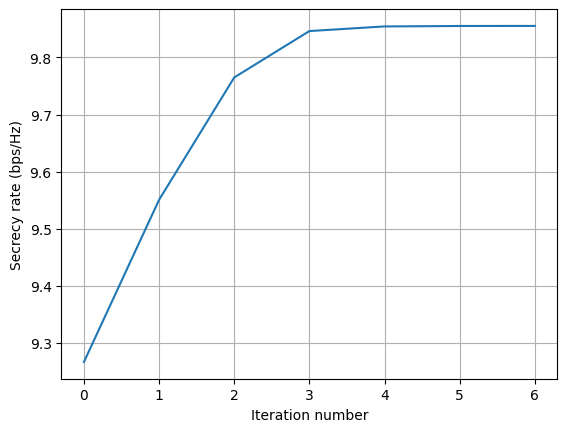

In [5]:
# Plot the iterates 
# N =4, Nris = 32, dABh = 10
plt.plot(rateSeq)
plt.xlabel('Iteration number')
plt.ylabel('Secrecy rate (bps/Hz)')
plt.grid(True)
plt.savefig("./Convergence.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Change N and N_ris

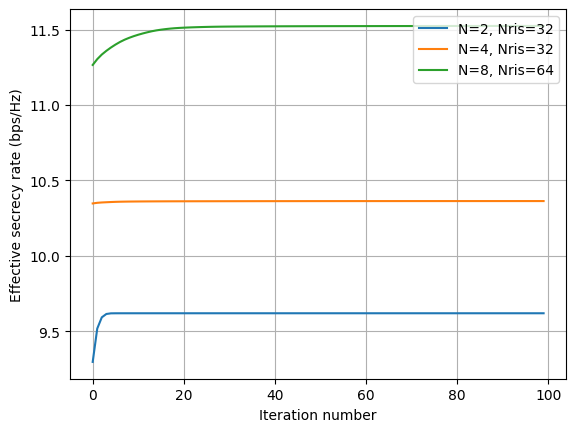

In [6]:
np.random.seed(0)
NandNris = [[2,32], [4,32], [8,64]]
effectiveRate = []
for x in NandNris:
    N = x[0]
    Nris = x[1]
    dABh = 10
    dAB = np.sqrt(dABh**2 + dv**2)
    dIE = np.sqrt((dAEh - dAI)**2 + dv**2)
    dIB = np.sqrt((dABh - dAI)**2 + dv**2)
    Hai = chanGen(zetaAI, dAI, Nris, N)
    hib = normFact*chanGen(zetaIB, dIB, 1, Nris)
    hie = normFact*chanGen(zetaIE, dIE, 1, Nris)
    hab = normFact*chanGen(zetaAB, dAB, 1, N)
    hae = normFact*chanGen(zetaAE, dAE, 1, N)
    thetaCurrent = np.ones((Nris,),dtype=complex)
    rateSeq = np.array([])
    # relChange = 1e3
    # epsilon = 1e-5
    iteration = 0
    while iteration < 100:
        wCurrent = updateW(thetaCurrent, N)
        thetaCurrent = updateTheta(wCurrent, thetaCurrent, Nris)
        rateSeq = np.append(rateSeq,rateCalc(wCurrent,thetaCurrent))
        # if len(rateSeq) > 3:
        #     relChange = abs(rateSeq[-1] - rateSeq[-2]) 
        iteration += 1
    effectiveRate.append(rateSeq)

plt.figure()

for i in range(len(NandNris)):
    plt.plot(np.arange(len(effectiveRate[i])), effectiveRate[i], label=f'N={NandNris[i][0]}, Nris={NandNris[i][1]}')

plt.xlabel('Iteration number')
plt.ylabel('Effective secrecy rate (bps/Hz)')
plt.legend()
plt.grid(True)
plt.show()

## Diagram showing position of each element
![Vị trí của các thành phần](image/position.png)

## Plot diagram the variation of ESR

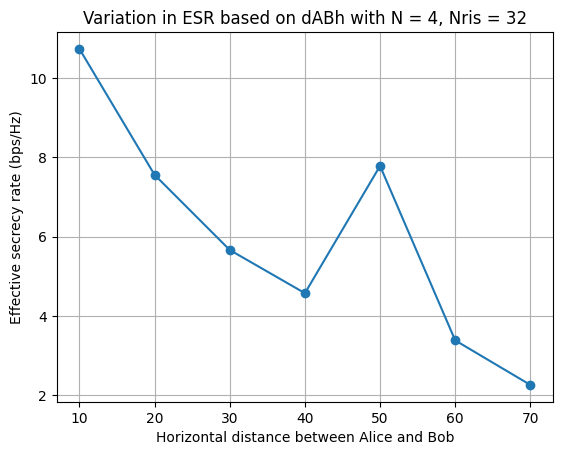

In [7]:
np.random.seed(0)
dABh = [10, 20, 30, 40, 50, 60, 70]
effectiveRate = []
for x in dABh:
    dAB = np.sqrt(x**2 + dv**2)
    dIE = np.sqrt((dAEh - dAI)**2 + dv**2)
    dIB = np.sqrt((x - dAI)**2 + dv**2)
    Hai = chanGen(zetaAI, dAI, Nris, N)
    hib = normFact*chanGen(zetaIB, dIB, 1, Nris)
    hie = normFact*chanGen(zetaIE, dIE, 1, Nris)
    hab = normFact*chanGen(zetaAB, dAB, 1, N)
    hae = normFact*chanGen(zetaAE, dAE, 1, N)
    thetaCurrent = np.ones((Nris,),dtype=complex)
    rateSeq = np.array([])
    relChange = 1e3
    epsilon = 1e-5
    while relChange > epsilon:
        wCurrent = updateW(thetaCurrent, N)
        thetaCurrent = updateTheta(wCurrent, thetaCurrent, Nris)
        rateSeq = np.append(rateSeq,rateCalc(wCurrent,thetaCurrent))
        if len(rateSeq) > 3:
            relChange = abs(rateSeq[-1] - rateSeq[-2])
    effectiveRate.append(rateSeq[-1])
plt.plot(dABh, effectiveRate, marker='o', linestyle='-')
plt.xlabel('Horizontal distance between Alice and Bob')
plt.ylabel('Effective secrecy rate (bps/Hz)')
plt.grid(True)
plt.title("Variation in ESR based on dABh with N = 4, Nris = 32")
plt.show()

# Kết luận

- Với RIS kích thước lớn có thể nâng cao được hiệu quả truyền tin bí mật
- Khi số lượng anten tại Alice cũng như số phần tử phản chiếu trên RIS tăng dẫn đến ESR tăng